In [1]:
%matplotlib ipympl
import time
import traceback
from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
import matplotlib.dates as md


from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
# from onix.analysis.t_violation import TViolation
from uncertainties import ufloat

import influxdb_client
from influxdb_client import Point
from influxdb_client.client.write_api import SYNCHRONOUS
import os
import datetime
import pytz
import tzlocal

In [2]:
def gaussian(f, f_0, a, sigma, b, c):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

def get_gaussian_fit(detunings, voltages, p0=None, bounds=None):
    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f_0": 0, "c": 1, "b": 0, "sigma": 1})
    if p0 is not None:
        fitter.set_p0(p0)
    if bounds is not None:
        for bound_var, bound in bounds.items():
            fitter.set_bounds(bound_var, bound[0], bound[1])
    fitter.fit(maxfev = 1000000)
    return fitter

def gaussian0(f, f0, a, sigma): 
    return a * np.exp( -(f - f0) **2 / (2 * sigma ** 2) )
    
def gaussianC(f, f0, a, sigma, c): 
    return a * np.exp( -(f - f0) **2 / (2 * sigma ** 2) ) + c

def get_gaussianC_fit(detunings, voltages, p0=None):
    fitter = Fitter(gaussianC)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    if p0 is not None:
        fitter.set_p0(p0)
    fitter.fit()
    
    return fitter

def two_peak_gaussian(f, f1, f2, a1, a2, sigma1, sigma2, b, c):
    return gaussian0(f, f1, a1, sigma1) + gaussian0(f, f2, a2, sigma2) + c + b * f

def four_peak_gaussian(f, f1, f2, f3, f4, a1, a2, a3, a4, sigma1, sigma2, sigma3, sigma4):
    return gaussian0(f, f1, a1, sigma1) + gaussian0(f, f2, a2, sigma2) + gaussian0(f, f3, a3, sigma3) + gaussian0(f, f4, a4, sigma4) + c

def linear(x, a, b):
    return x * a + b

In [3]:
def averaged_data_from_number(data_number, return_err = False):
    data, headers = get_experiment_data(data_number)
    transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"], return_err = return_err)
    monitors_avg = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"], return_err = return_err)
    return (transmissions_avg, monitors_avg, headers)

In [4]:
def gaussian_fits_from_data(transmissions_avg, monitors_avg, headers, default_p0=None):
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0

    p0 = {"sigma": 0.5, "a": -0.1, "b": -0.00001, "c": np.max(antihole_normalized)}
    if default_p0 is None:
        default_p0 = {}
    p0.update(default_p0)
    
    if not use_field_plate:
        fits = {0: {}}
        antihole_fit = get_gaussian_fit(detunings, antihole_normalized, p0=p0)
        fits[0]["ah"] = antihole_fit
        
        rf_fit = get_gaussian_fit(detunings, rf_normalized, p0=p0)
        fits[0]["rf"] = rf_fit
    else:
        fits = {1: {}, -1: {}}
        for label in fits.keys():
            use_positive_stark_shift = label > 0
            if use_positive_stark_shift:
                mask = detunings > 0
            else:
                mask = detunings < 0
            p0["f_0"] = label * abs(headers["params"]["field_plate"]["stark_shift"].to("MHz").magnitude)
            antihole_fit: Fitter = get_gaussian_fit(detunings[mask], antihole_normalized[mask], p0=p0)
            fits[label]["ah"] = antihole_fit
            
            rf_fit: Fitter = get_gaussian_fit(detunings[mask], rf_normalized[mask], p0=p0)
            fits[label]["rf"] = rf_fit
    return fits

In [5]:
def ah_parameters_from_data(transmissions_avg, monitors_avg, headers):
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0
    
    if not use_field_plate:
        off_resonant_index = np.argmax(np.abs(detunings) > 0)
        on_resonant_index = 1 - off_resonant_index
        heights = {0: {}}
        backgrounds = {0: {}}
        heights[0]["ah"] = 1 - antihole_avg[on_resonant_index] / antihole_avg[off_resonant_index]
        heights[0]["rf"] = 1 - rf_avg[on_resonant_index] / rf_avg[off_resonant_index]
        backgrounds[0]["ah"] = antihole_avg[off_resonant_index]
        backgrounds[0]["rf"] = rf_avg[off_resonant_index]
    else:
        off_resonant_index_1 = 1
        off_resonant_index_2 = 0
        # off_resonant_index_2 = 1
        on_resonant_index_1 = 3
        on_resonant_index_2 = 2

        heights = {1: {}, -1: {}}
        backgrounds = {1: {}, -1: {}}

        heights[1]["ah"] = 1 - antihole_avg[on_resonant_index_1] / antihole_avg[off_resonant_index_1]
        heights[1]["rf"] = 1 - rf_avg[on_resonant_index_1] / rf_avg[off_resonant_index_1]
        heights[-1]["ah"] = 1 - antihole_avg[on_resonant_index_2] / antihole_avg[off_resonant_index_2]
        heights[-1]["rf"] = 1 - rf_avg[on_resonant_index_2] / rf_avg[off_resonant_index_2]

        backgrounds[1]["ah"] = antihole_avg[off_resonant_index_1]
        backgrounds[1]["rf"] = rf_avg[off_resonant_index_1]
        backgrounds[-1]["ah"] = antihole_avg[off_resonant_index_2]
        backgrounds[-1]["rf"] = rf_avg[off_resonant_index_2]
    return (heights, backgrounds)

In [6]:
def rf_spectroscopy_ah_ratio(data_numbers, method="auto", return_err=False):
    rf_heights = {}
    antihole_heights = {}
    rf_backgrounds = {}
    antihole_backgrounds = {}
    headers = []
    for data_number in data_numbers:
        transmissions_avg, monitors_avg, headers_single = averaged_data_from_number(data_number, return_err=return_err)
        if method == "auto":
            detunings_len = len(headers_single["detunings"])
            if detunings_len > 4:
                method = "fit"
            else:
                method = "ratio"
        if method == "fit":
            try:
                fits = gaussian_fits_from_data(transmissions_avg, monitors_avg, headers_single)
            except RuntimeError as e:
                print(f"Fitting error for data number #{data_number}:")
                raise e
            for label in fits:
                if label not in rf_heights:
                    rf_heights[label] = []
                    antihole_heights[label] = []
                    rf_backgrounds[label] = []
                    antihole_backgrounds[label] = []
                rf_heights[label].append(abs(fits[label]["rf"].results["a"]) / fits[label]["rf"].results["c"])
                antihole_heights[label].append(abs(fits[label]["ah"].results["a"]) / fits[label]["ah"].results["c"])
                rf_backgrounds[label].append(fits[label]["rf"].results["c"])
                antihole_backgrounds[label].append(fits[label]["ah"].results["c"])
        elif method == "ratio":
            heights, backgrounds = ah_parameters_from_data(transmissions_avg, monitors_avg, headers_single)
            # heights, backgrounds = ah_parameters_from_data1(data_number)
            for label in heights:
                if label not in rf_heights:
                    rf_heights[label] = []
                    antihole_heights[label] = []
                    rf_backgrounds[label] = []
                    antihole_backgrounds[label] = []
                rf_heights[label].append(heights[label]["rf"])
                antihole_heights[label].append(heights[label]["ah"])
                rf_backgrounds[label].append(backgrounds[label]["rf"])
                antihole_backgrounds[label].append(backgrounds[label]["ah"])
        headers.append(headers_single)
    for label in rf_heights:
        rf_heights[label] = np.array(rf_heights[label])
        antihole_heights[label] = np.array(antihole_heights[label])
        rf_backgrounds[label] = np.array(rf_backgrounds[label])
        antihole_backgrounds[label] = np.array(antihole_backgrounds[label])
    return (rf_heights, antihole_heights, rf_backgrounds, antihole_backgrounds, headers)

## HIGH FREQUENCY SPECTROSCOPY

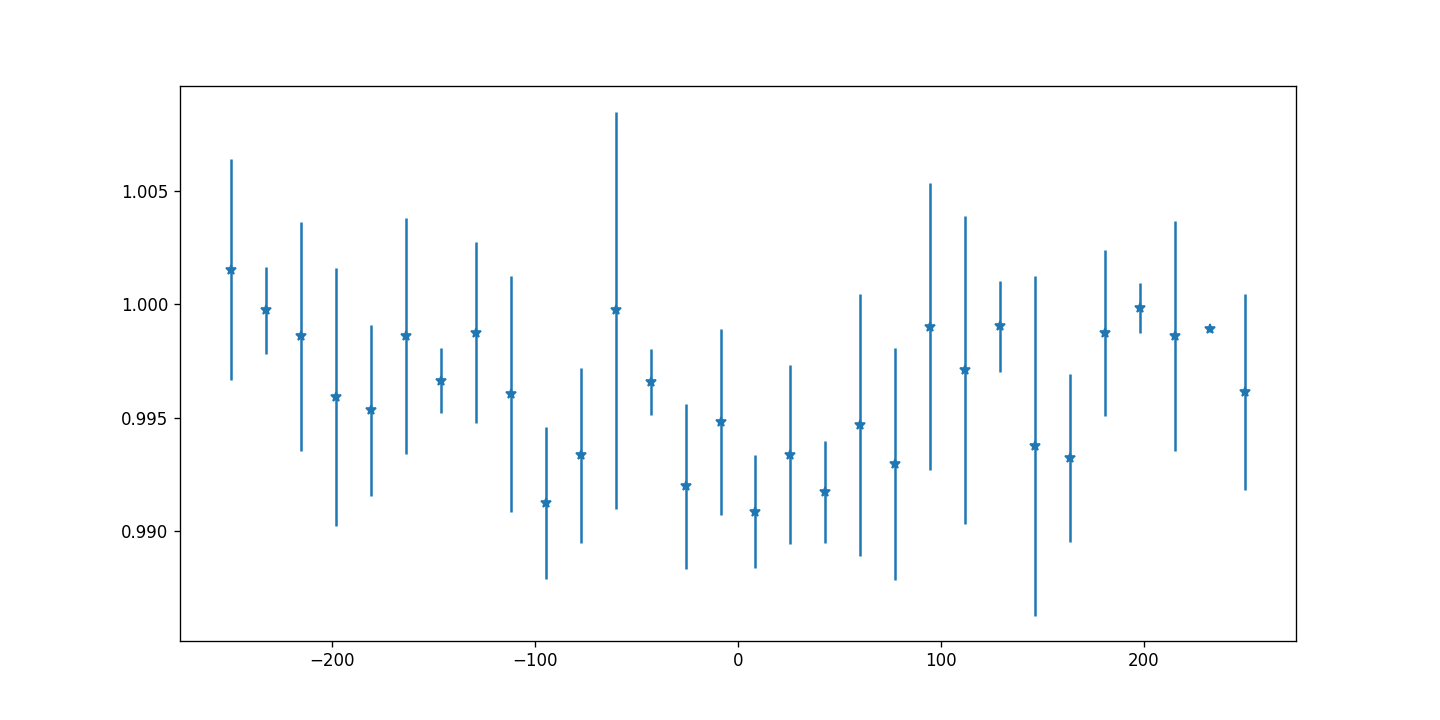

In [128]:
data_list = range(1983600, 1983615+1) # 1ms
data_list = range(1983637, 1983734+1) # 0.2ms
rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
xs_dupe = [header["params"]["rf"]["detuning"].to("kHz").magnitude for header in headers]
ys_dupe = rf_heights[0] / ah_heights[0]

xs = list(set(xs_dupe))
ys = [np.average([ys_dupe[i] for i in range(len(ys_dupe)) if xs_dupe[i] == xs[j]]) for j in range(len(xs))]
ys_err = [np.std([ys_dupe[i] for i in range(len(ys_dupe)) if xs_dupe[i] == xs[j]]) for j in range(len(xs))]

fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
ax.errorbar(xs, ys, ys_err, ls="", marker="*")
plt.show()

## RABI FLOPPING

In [325]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)
    
def flopping(t, contrast, freq, phase, tau, c):
    return contrast*np.cos(2*np.pi*freq*t+phase)*np.exp(-t/tau) + c

def get_flopping_fit(xs, ys):
    fitter = Fitter(flopping)
    fitter.set_absolute_sigma(False)
    fitter.set_data(xs, ys)
    fitter.set_p0({"contrast": 0.02, "freq": 1/(0.2), "phase": 0, "tau": 0.4, "c": 0.98})
    fitter.set_bounds("contrast", -1, 1)
    fitter.set_bounds("freq", 0, 6)
    fitter.set_bounds("phase", -0.2, 0.2)
    fitter.set_bounds("tau", 0, 10)
    fitter.fit(maxfev = 1000000)
    return fitter

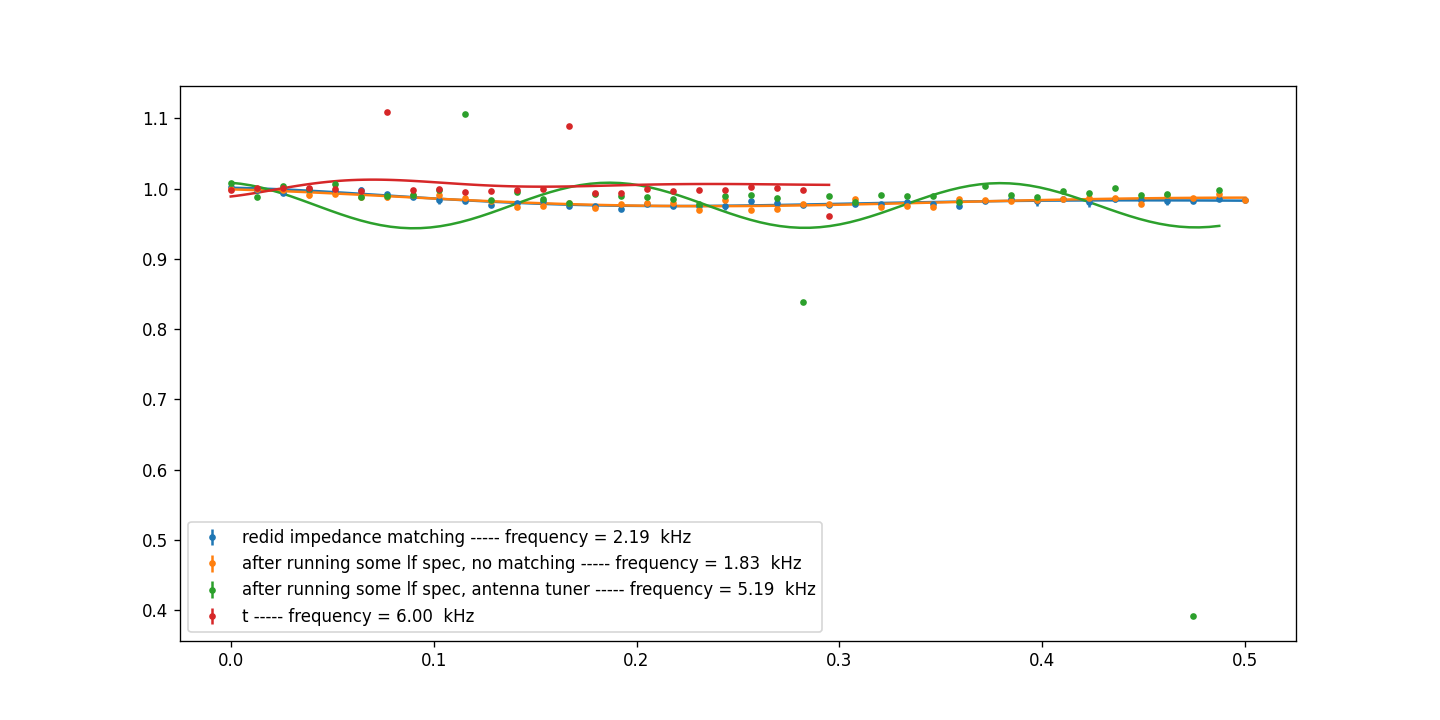

0.1282051282051282


In [410]:
# data_list = range(1982178, 1982219+1)
# data_list = range(1983408, 1983708+1)

data = {
    # "impedance matched - 9000 amplitude": (1983828, 1983913),
    # "impedance matched - 10000 amplitude, changed some params": (1984007, 1984086),
    # "no impedance matching 1": (1984101, 1984139),
    # "no imedpance matching 2": (1985097, 1985315),
    # "impedance matched - rotate ??": (1984148, 1984180),
    # "impedance matched - rotate CCW 30 deg": (1984185, 1984224),
    # "impedance matched - rotate CCW 45 deg": (1984226, 1984265),
    # "impedance matched - rotate CCW 10 deg": (1984290, 1984329),
    # "impedance matched - rotate CCW 10 deg 2": (1984559, 1984597),
    # "impedance matched - flipped connections": (1984794, 1985073),
    # "impedance matched - CW 45 deg": (1985342, 1985701),
    # "impedance matched - CW 10 deg": (1985745, 1985904),
    # "impedance matched - 2x longer cable from amp": (1985924, 1986041), 
    # "impedance matched - CW 10 deg 2": (1986050, 1986129),
    # "impedance matched - flipped connections back": (1986150, 1986629),
    # "impedance matched - CCW 45 deg": (1986670, 1986949),
    # "impedance matched - CCW 45 deg 2": (1987080, 1987239),
    # "impedance matched - flipped back again": (1987272, 1987308),
    # "impedance matched - CW 45 deg 2": (1987330, 1987489),
    # "impedance matched - CW 10 deg 3": (1987520, 1987679),
    # "impedance matched - CCW 45 deg 3": (1987701, 1987780),
    "redid impedance matching": (1987808, 1987887),
    # "added random junk parallel C": (1987892, 1987931),
    
    # "tuned with parallel C": (1988137, 1989149),
    # "antenna tuner SWR = 1": (1989283, 1989362),
    # "no impedance matching 3": (1989428, 1989587),
    "after running some lf spec, no matching": (1991261, 1991309),
    "after running some lf spec, antenna tuner": (1991310, 1991349),
    "t": (1991587, 1991611)
}

fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
for i, (label, data_range) in enumerate(data.items()):
    data_list = range(data_range[0], data_range[1]) # best Q -> ~-50 dB
    # data_list = range(1983828, 1983868+31) # best Q -> ~-50 dB
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs_dupe = [header["params"]["rf"]["duration"].to("ms").magnitude for header in headers]
    ys_dupe = rf_heights[0] / ah_heights[0]
    
    # UNIQUE xs
    xs = list(set(xs_dupe))
    ys = [np.average([ys_dupe[i] for i in range(len(ys_dupe)) if xs_dupe[i] == xs[j]]) for j in range(len(xs))]
    ys_err = [np.std([ys_dupe[i] for i in range(len(ys_dupe)) if xs_dupe[i] == xs[j]]) for j in range(len(xs))]

    # FIT
    xfit = np.linspace(min(xs), max(xs), 100)
    fitter = get_flopping_fit(xs, ys)
    
    ax.errorbar(xs, ys, ys_err, ls="", marker=".", label=label+f" ----- frequency = {fitter.results["freq"]:.2f}  kHz", color=f"C{i}")
    ax.plot(xfit, fitter.fitted_value(xfit), color=f"C{i}")

plt.legend()
plt.show()
print(xs[3])